In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/Colab Notebooks/Potato/traning")

# Potato Disease Classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [ ]:
class_names = dataset.class_names
class_names

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    p

#ModelBiuding

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Chuẩn bị mô hình transfer learning sử dụng DenseNet121
base_model = applications.DenseNet121(
    weights='imagenet',  # Sử dụng trọng số được huấn luyện trước trên ImageNet
    include_top=False,    # Không bao gồm lớp fully-connected đầu ra
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Đóng băng các layers của mô hình cơ sở để không huấn luyện lại chúng
for layer in base_model.layers:
    layer.trainable = False

# Xây dựng mô hình CNN
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Số lớp phản ánh số lớp trong dữ liệu
])




In [ ]:
# Biên dịch mô hình
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',  # Sử dụng sparse categorical crossentropy vì labels không được one-hot encoded
              metrics=['accuracy'])

# Hiển thị thông tin mô hình
model.summary()



In [ ]:
# Huấn luyện mô hình
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)


Epoch 1/50
54/54 [==============================] - 503s 9s/step - loss: 1.2317 - accuracy: 0.7481 - val_loss: 0.2352 - val_accuracy: 0.9271
Epoch 2/50
54/54 [==============================] - 500s 9s/step - loss: 0.2779 - accuracy: 0.9012 - val_loss: 0.1132 - val_accuracy: 0.9657
Epoch 3/50
54/54 [==============================] - 508s 9s/step - loss: 0.2390 - accuracy: 0.9172 - val_loss: 0.1247 - val_accuracy: 0.9583
Epoch 4/50
54/54 [==============================] - 505s 9s/step - loss: 0.2380 - accuracy: 0.9135 - val_loss: 0.0899 - val_accuracy: 0.9688
Epoch 5/50
54/54 [==============================] - 504s 9s/step - loss: 0.1853 - accuracy: 0.9363 - val_loss: 0.1233 - val_accuracy: 0.9583
Epoch 6/50
54/54 [==============================] - 501s 9s/step - loss: 0.1748 - accuracy: 0.9380 - val_loss: 0.0881 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 506s 9s/step - loss: 0.1601 - accuracy: 0.9416 - val_loss: 0.0806 - val_accuracy: 0.9792
Epoch 8/50
54

In [ ]:

# Đánh giá mô hình trên tập kiểm thử
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8922056555747986,
 0.6417027115821838,
 0.39938703179359436,
 0.3158038556575775,
 0.27838191390037537]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

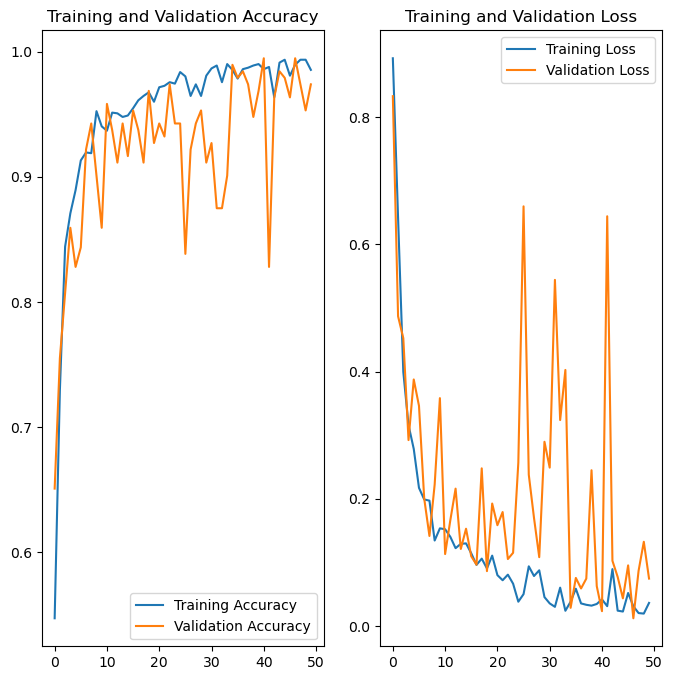

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 875ms/step
predicted label: Potato___Early_blight


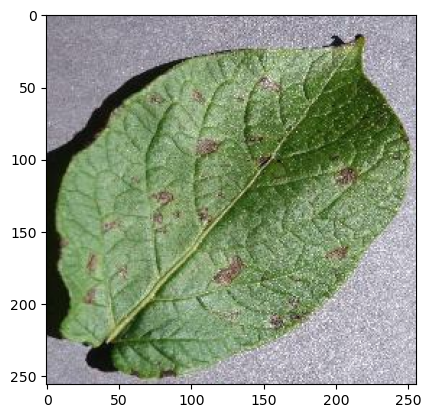

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 39ms/step


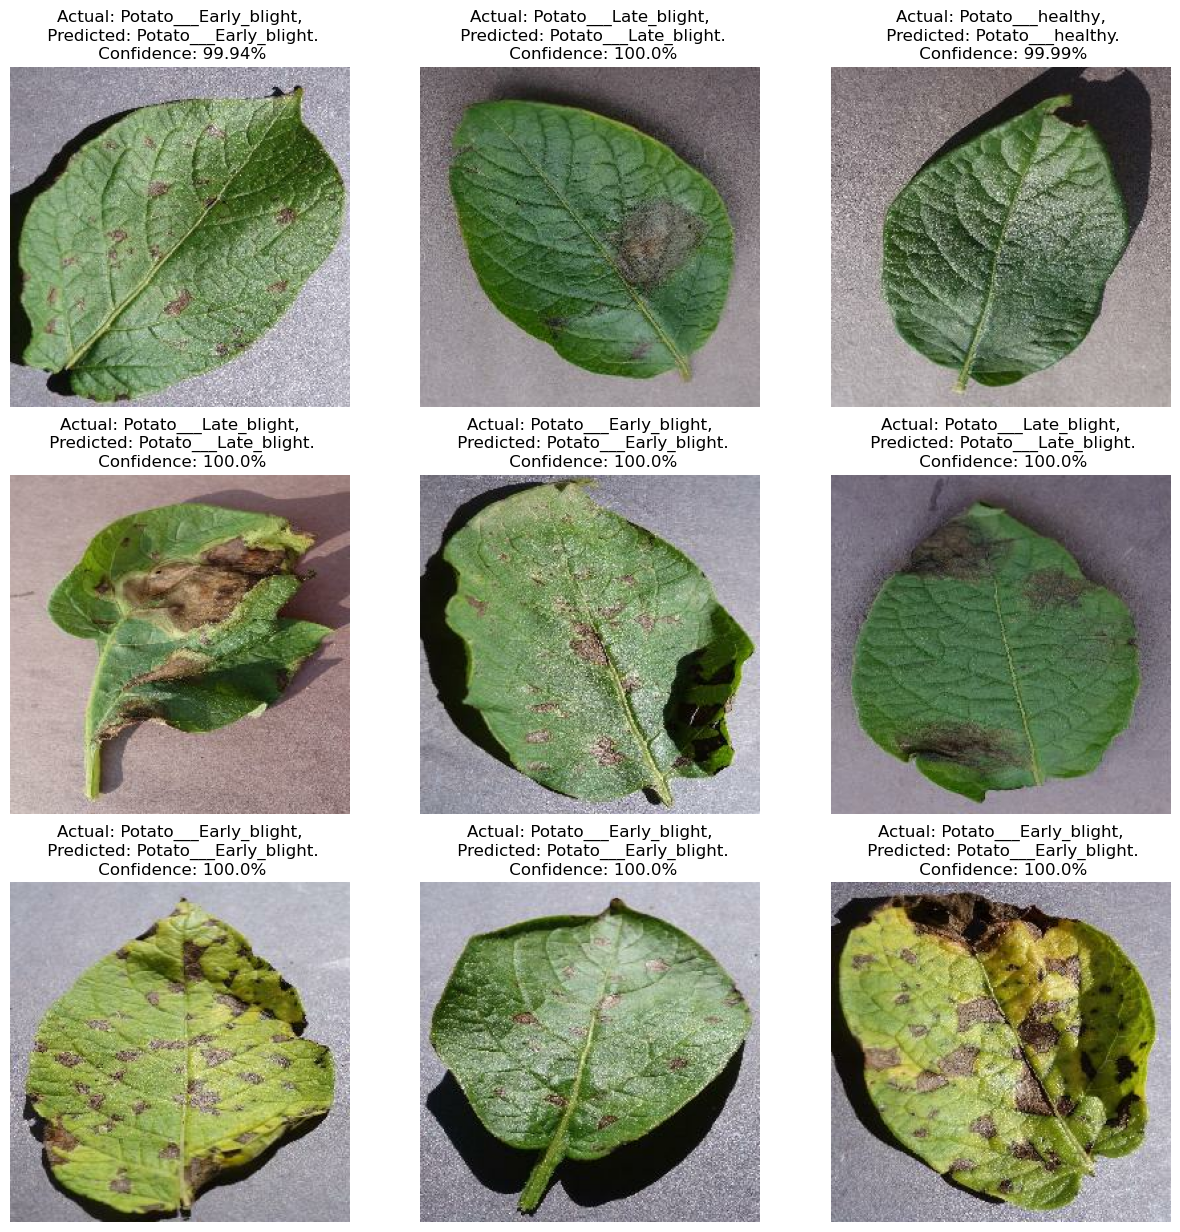

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [ ]:
model.save("../potatoes.h5")